In [55]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# Load configuration and keep necessary
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = Path(r"C:\Probook\E\AI\Projects\Data Science\Airbnb Price Prediction\Data\AB_US_2020.csv")

COLUMNS = [
    "id", "latitude", "longitude", "room_type", "price",
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "city"
]

In [56]:
# loading the dataset with only the required columns.

print("\n[Load] Reading dataset...")
df = pd.read_csv(DATA_PATH, usecols=COLUMNS, low_memory=False)
print(f"[Load] Shape: {df.shape}")
print(f"[Load] Missing values summary:\n{df.isna().sum()}\n")


[Load] Reading dataset...
[Load] Shape: (226030, 11)
[Load] Missing values summary:
id                                    0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 48602
calculated_host_listings_count        0
availability_365                      0
city                                  0
dtype: int64



In [57]:
# cleaning steps.

before = len(df)
df = df.dropna(subset=["price", "latitude", "longitude", "room_type", "city"]).copy()
df = df[(df["price"] > 10) & (df["price"] < 5000)].copy()
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Compress the long tail of rare cities into a single 'Other' category.
top_cities = df["city"].value_counts().nlargest(20).index
df.loc[~df["city"].isin(top_cities), "city"] = "Other"

print(f"[Clean] Removed rows: {before - len(df)} | Remaining: {len(df)}")


[Clean] Removed rows: 666 | Remaining: 225364



[EDA] Basic price distribution and patterns...


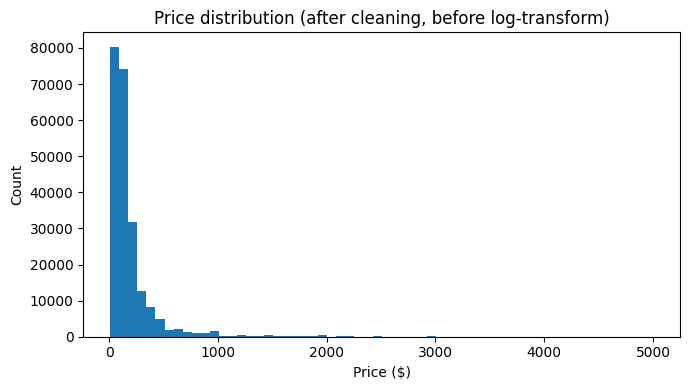

<Figure size 600x400 with 0 Axes>

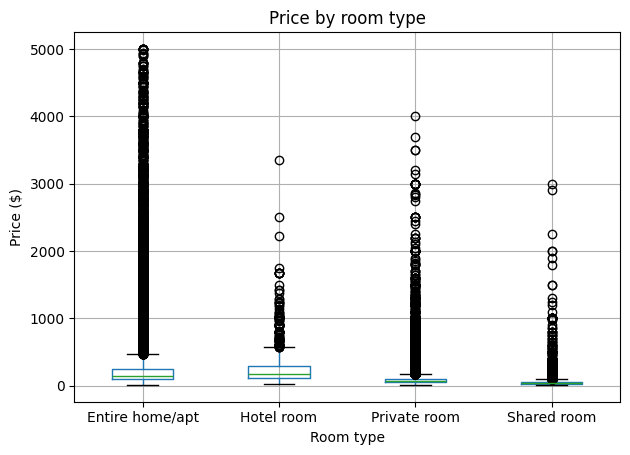

Full Map


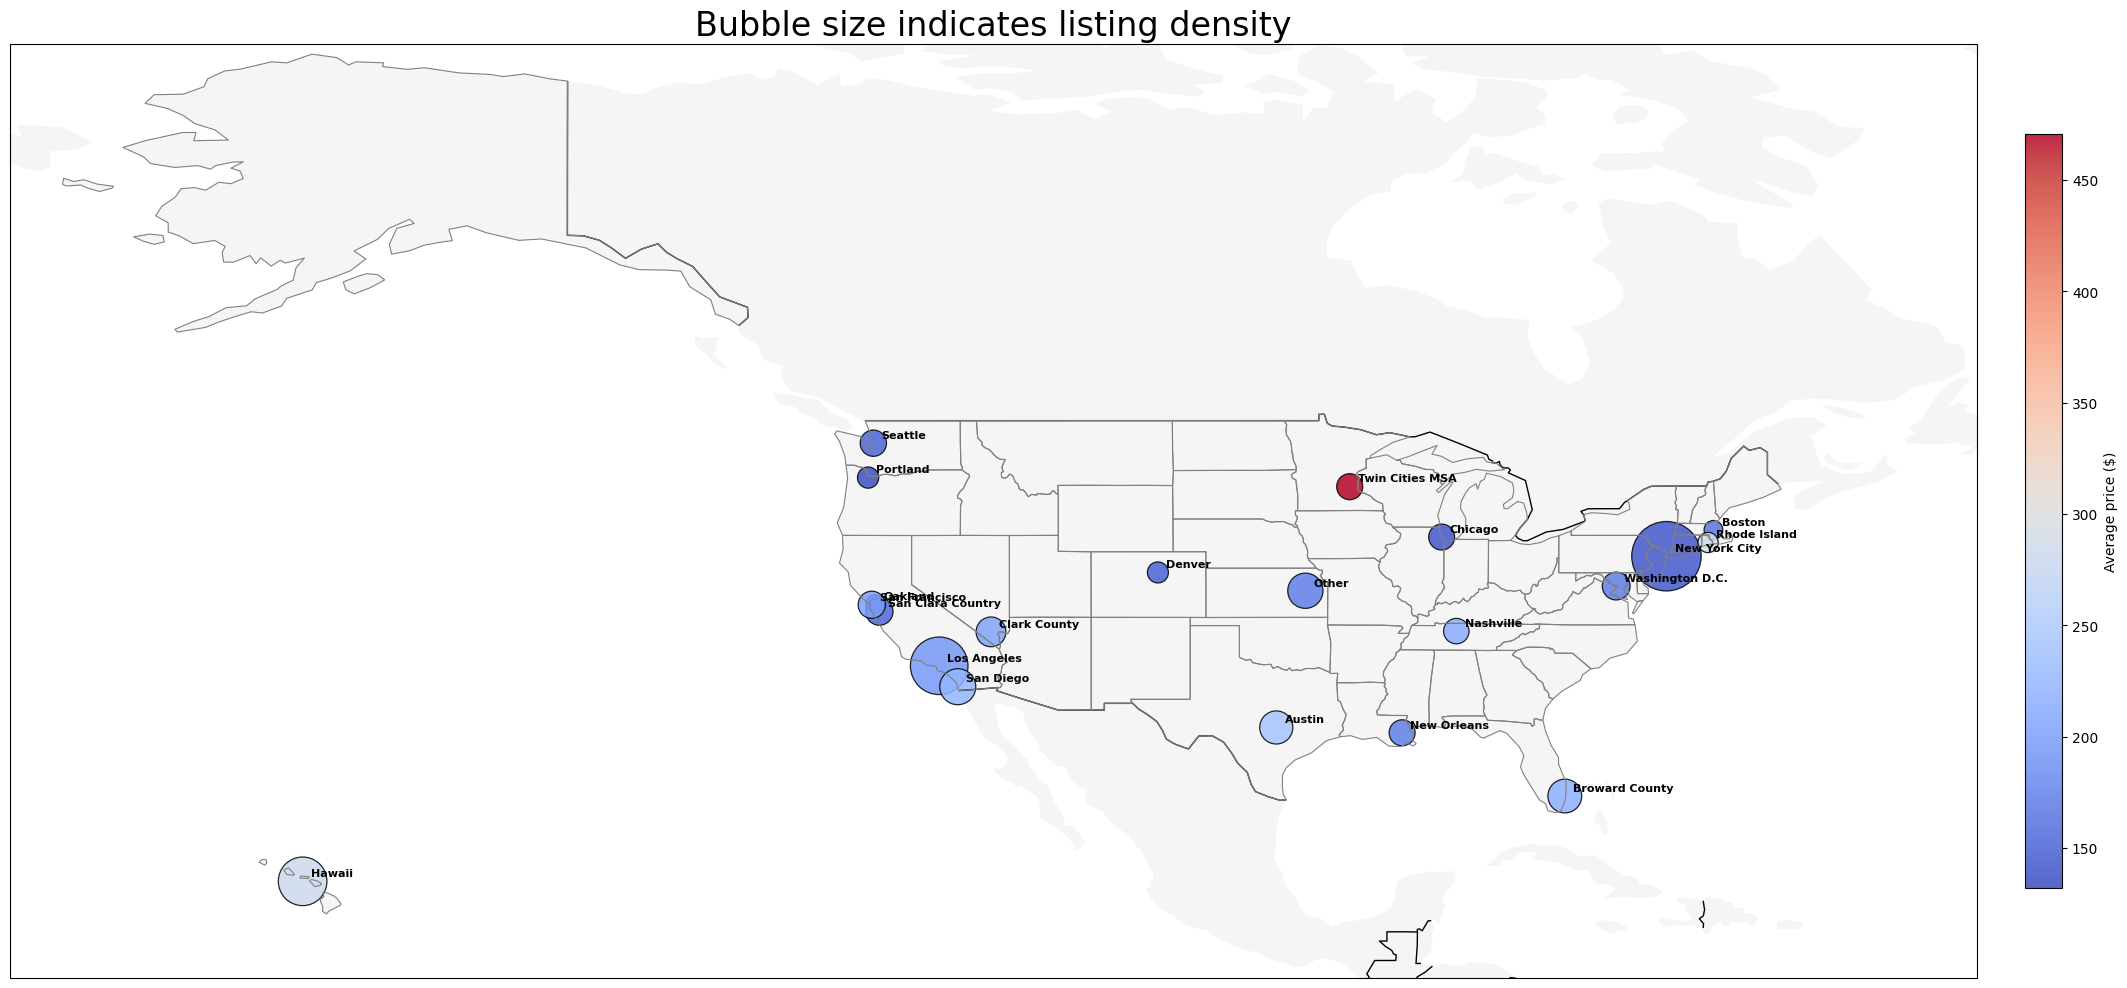


[EDA] Top 5 cities by median price:
city
Clark County       141.0
Nashville          150.0
Twin Cities MSA    150.0
Hawaii             187.0
Rhode Island       200.0
Name: price, dtype: float64


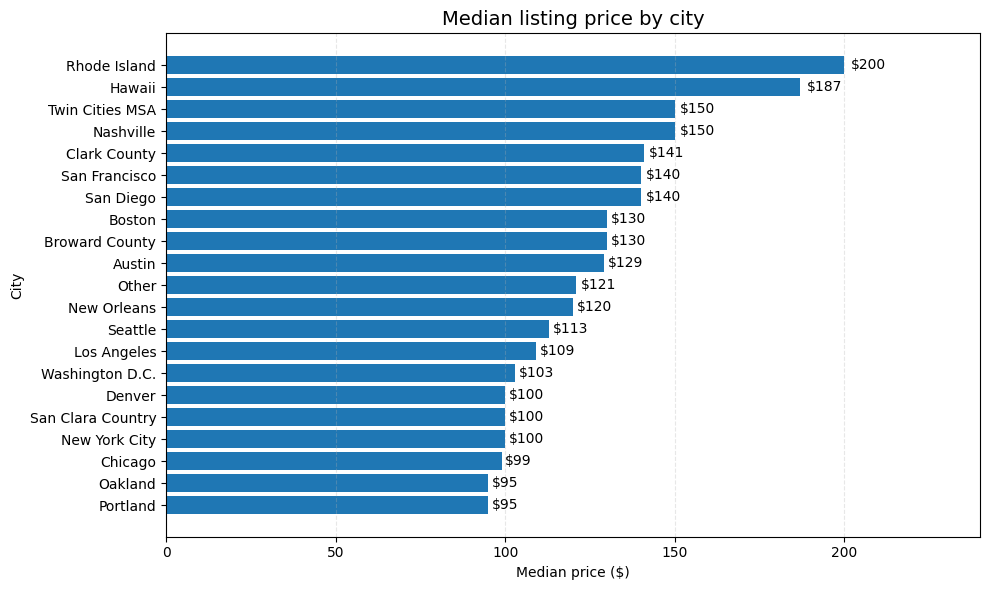

In [58]:
print("\n[EDA] Basic price distribution and patterns...")

try:
    # 1) Histogram
    plt.figure(figsize=(7, 4))
    plt.hist(df["price"], bins=60)
    plt.title("Price distribution (after cleaning, before log-transform)")
    plt.xlabel("Price ($)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 2) Boxplot
    plt.figure(figsize=(6, 4))
    df.boxplot(column="price", by="room_type")
    plt.title("Price by room type")
    plt.suptitle("")
    plt.xlabel("Room type")
    plt.ylabel("Price ($)")
    plt.tight_layout()
    plt.show()

    # 3) MAP
    print("Full Map")
    fig = plt.figure(figsize=(24, 14))
    proj = ccrs.PlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([-175, -55, 15, 72], crs=proj)

    ax.add_feature(cfeature.LAND, facecolor="whitesmoke")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor="gray")

    scatter = ax.scatter(
        city_stats["lon"], city_stats["lat"],
        s=(city_stats["count"] / city_stats["count"].max()) * 2500,
        c=city_stats["avg_price"],
        cmap="coolwarm",
        alpha=0.85,
        edgecolor="black",
        linewidth=0.9,
        transform=proj,
    )

    for _, r in city_stats.iterrows():
        ax.text(r["lon"] + 0.5, r["lat"] + 0.3, r["city"],
                fontsize=8, fontweight="bold", color="black",
                transform=proj)

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.55, pad=0.02)
    cbar.set_label("Average price ($)")


    plt.title("Bubble size indicates listing density", fontsize=24)
    plt.tight_layout()
    plt.show()


    # 4) Median Prices by City
    medians = df.groupby("city")["price"].median().sort_values()

    print("\n[EDA] Top 5 cities by median price:")
    print(medians.tail(5))

    plt.figure(figsize=(10, 6))
    plt.barh(medians.index, medians.values)
    plt.title("Median listing price by city", fontsize=14)
    plt.xlabel("Median price ($)")
    plt.ylabel("City")
    plt.xlim(0, medians.max() * 1.2)
    plt.grid(axis="x", linestyle="--", alpha=0.3)

    for i, v in enumerate(medians.values):
        plt.text(v * 1.01, i, f"${v:.0f}", va="center")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"[EDA] Plots skipped ({e})")


In [59]:
# Define which features will be used and log-transform the target.

df["price_log"] = np.log1p(df["price"])

NUM_COLS = [
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "latitude", "longitude"
]
CAT_COLS = ["room_type", "city"]

# Simple and transparent encoding of categorical variables.
X_num = df[NUM_COLS].copy()
X_cat = pd.get_dummies(df[CAT_COLS], drop_first=True)
X = pd.concat([X_num, X_cat], axis=1)
y = df["price_log"].values

print(f"\n[Features] X shape: {X.shape} | y length: {len(y)}")


[Features] X shape: (225364, 30) | y length: 225364


In [60]:
# Split the dataset into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f"[Split] Train: {X_train.shape} | Test: {X_test.shape}")


[Split] Train: (180291, 30) | Test: (45073, 30)


In [61]:
# Standardize numeric features 
scaler = StandardScaler()

# Work on copies so the original frames remain clean
X_train = X_train.copy()
X_test = X_test.copy()

# Force numeric columns to float32 before scaling
X_train[NUM_COLS] = X_train[NUM_COLS].astype(np.float32)
X_test[NUM_COLS]  = X_test[NUM_COLS].astype(np.float32)

# Apply standardization safely
X_train.loc[:, NUM_COLS] = scaler.fit_transform(X_train[NUM_COLS])
X_test.loc[:,  NUM_COLS]  = scaler.transform(X_test[NUM_COLS])

In [62]:
# Configure and train the XGBoost model.

params = dict(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.08,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=4,
    verbosity=0
)
model = xgb.XGBRegressor(**params)

print("\n[Train] Training XGBoost model...")
model.fit(X_train, y_train, verbose=False)


[Train] Training XGBoost model...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [63]:
# Evaluate the model on the test set.

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))

print(f"[Test] RMSE=${rmse:,.2f} | MAE=${mae:,.2f} | R²={r2:.3f}")

[Test] RMSE=$235.94 | MAE=$87.62 | R²=0.323


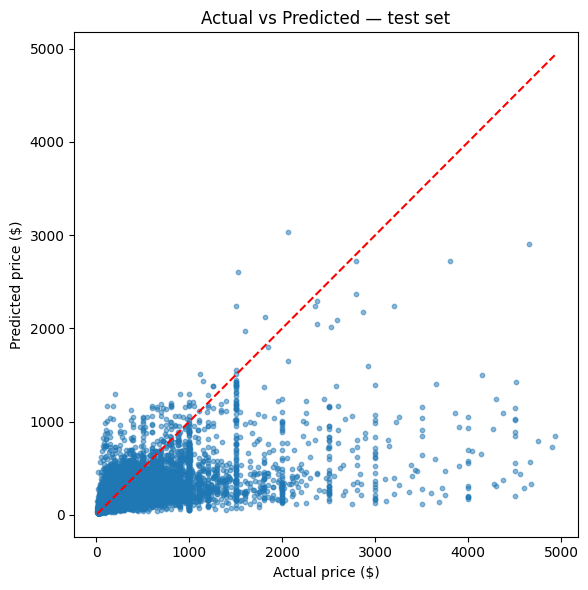

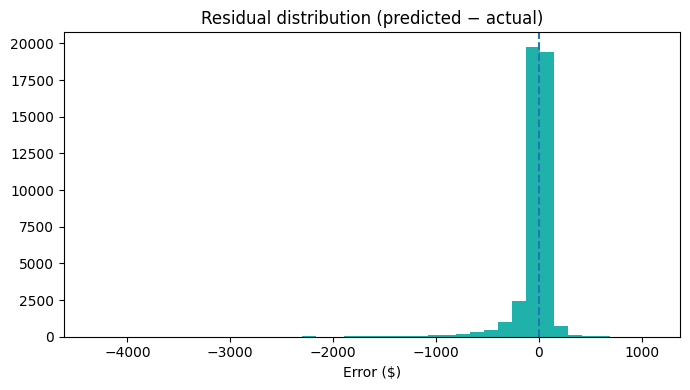

In [64]:
# Visualization

try:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    low, high = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    plt.plot([low, high], [low, high], "--", color="red")
    plt.xlabel("Actual price ($)")
    plt.ylabel("Predicted price ($)")
    plt.title("Actual vs Predicted — test set")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(y_pred - y_true, bins=40, color="lightseagreen")
    plt.axvline(0, linestyle="--")
    plt.title("Residual distribution (predicted − actual)")
    plt.xlabel("Error ($)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Plot] Skipped due to environment: {e}")

In [66]:
# Save the predictions
output = pd.DataFrame({"ActualPrice": y_true, "PredictedPrice": y_pred})
output_file = "Airbnb_XGB_Baseline_Results.csv"
output.to_csv(output_file, index=False)
print(f"[Save] File written: {output_file}")

[Save] File written: Airbnb_XGB_Baseline_Results.csv
